Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


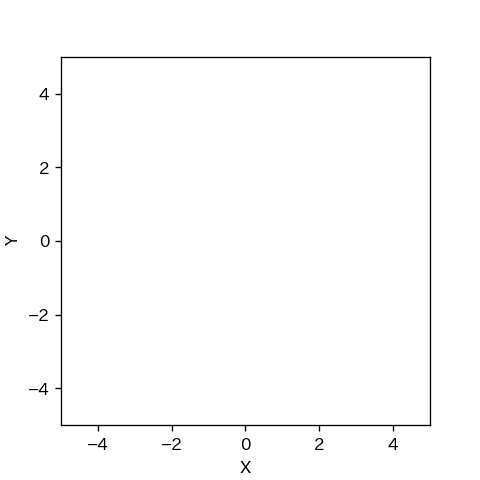

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_trap_phantom_kidnap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m,phantom_prob=0.1), agent=a, color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [4]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_trap_phantom_kidnap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0 真値: [-3.54004055 -1.81192558  3.30240401] 推定値: [0.96429813 0.25199517 6.26725962] 誤差: 4.95467817408054
1 真値: [ 5.8826493   3.23243972 -0.05892171] 推定値: [ 0.88811137 -1.61188287  4.69843732] 誤差: 6.957935796104166
2 真値: [ 2.12167247 -5.80595256  5.81687538] 推定値: [ 0.26791716 -4.45403396  4.38719867] 誤差: 2.294361054739102
3 真値: [ 6.9024213  -2.21137366  1.85760853] 推定値: [4.45701369 1.05754871 7.1548322 ] 誤差: 4.082385552967738
4 真値: [-2.50984578 -1.05488236  4.2016577 ] 推定値: [-6.88772789  3.31722107 -0.59664081] 誤差: 6.187175460886368
5 真値: [ 6.74952201 -1.44941914  2.07575321] 推定値: [ 1.74634592 -1.80579063  1.10433086] 誤差: 5.015852029087608
6 真値: [1.40257422 0.10389673 2.69644802] 推定値: [-4.82705345 -3.84847507  1.32881225] 誤差: 7.377635384925095
7 真値: [ 3.35810948 -0.44319168  2.07198227] 推定値: [ 3.98049533 -0.06363725  2.24035865] 誤差: 0.7289895123861709
1
8 真値: [0.07386921 0.32957336 5.01456431] 推定値: [-4.16099527 -4.94419683  0.07515421] 誤差: 6.763632834774887
9 真値: [-2.65181341 -1.0480467

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-0.0589473  -1.75287073  4.23565754] 推定値: [ 1.79074499  0.3403278  -0.50184276] 誤差: 2.7933567030716144
21 真値: [ 4.27766079  3.66815265 -1.71883527] 推定値: [ 2.46523453  4.10515818 -0.15215169] 誤差: 1.8643665941049563
22 真値: [ 4.16777247  0.84228781 -0.31324664] 推定値: [-4.93049926  4.20312395  1.68172091] 誤差: 9.69916326154629
23 真値: [ 0.57248949 -6.58745322  6.46697348] 推定値: [ 5.05217353 -4.76249909  1.59486787] 誤差: 4.837150679856674
24 真値: [-2.72801384  3.99550051  4.36075488] 推定値: [-5.76900591  1.07948496  0.67544771] 誤差: 4.213167386768513
25 真値: [ 0.98795194 -0.98482205  2.34087173] 推定値: [-9.01770798 -1.26897664  0.29594672] 誤差: 10.009694013886145
26 真値: [ 5.12899211 -4.98922336  1.19929532] 推定値: [ 5.97361126  6.88109696 -2.92151679] 誤差: 11.900331340441605
27 真値: [-3.17567156  2.24960675  2.61872838] 推定値: [-4.9449256  1.8320621 -0.6029166] 誤差: 1.8178568194647309
28 真値: [1.31917022 1.68949301 4.91863919] 推定値: [ 0.77807645 -7.83249069  1.44384886] 誤差: 9.5373453415825
29 真値: [-3.730